# **Arms Trade: Clustering**

## Objectives

* The goal of this notebook is to cluster countries based on their trade behaviour 
* I hope to discover 3 clusters: Major Importer, Major Exporter and Balanced Trader

## Inputs

* Like the last section, this notebook requires the processed dataset 'arms_trade_cleaned.csv' as found in the data_folder/Processed path

## Outputs

* First and foremost a ML clustering pipeline will be produced
* Following on from this a small dataframe will be created to join the cluster labels to the main dataset 




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\jackr\\OneDrive\\Desktop\\my_projects\\Capstone\\Arms-Import-Export-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\jackr\\OneDrive\\Desktop\\my_projects\\Capstone\\Arms-Import-Export-Analysis'

# Preprocessing and Scaling

In this section the features for the pipeline will be chosen and necessary scaling and processing steps will be applied

Importing the necessary libraries.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

Retrieving dataset

In [5]:
arms_enhance_df = pd.read_csv('data_folder/Processed/arms_trade_cleaned.csv')
arms_enhance_df.head()

,OrderDate,TransactionID,Recipient,Supplier,Number ordered,Weapon designation,Weapon description,Number delivered,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons,Supplier_Total_TIV,Recipient_Total_TIV,Trade_Volume,Decade,Trade_Frequency
0,2002-01-01,Russia_2002.0_0,Afghanistan,Russia,3.0,Mi-17,transport helicopter,3.0,Second hand,Second-hand; aid,2.90,8.70,8.70,165817.26,15809.14,11,2000.0,6
1,2007-01-01,Turkiye_2007.0_1,Afghanistan,Turkiye,24.0,M-114 155mm,towed gun,24.0,Second hand,Second-hand; aid,0.20,4.80,4.80,6689.54,15809.14,1,2000.0,1
2,2004-01-01,United States_2004.0_2,Afghanistan,United States,188.0,M-113,armoured personnel carrier,188.0,Second hand,Second-hand; aid; M-113A2 version; incl 15 M-5...,0.10,18.80,18.80,849588.93,15809.14,34,2000.0,3
3,2016-01-01,United States_2016.0_3,Afghanistan,United States,53.0,S-70 Black Hawk,transport helicopter,53.0,Second hand but modernized,Second-hand UH-60A modernized to UH-60A+ befor...,4.29,227.37,227.37,849588.93,15809.14,34,2010.0,31
4,1973-01-01,Soviet Union_1973.0_4,Afghanistan,Soviet Union,100.0,T-62,tank,100.0,New,No additional info,1.80,180.00,180.00,452121.07,15809.14,82,1970.0,25


Choosing features and assigning to X.

It was discovered in the last section that Trade_Volume vs Trade Frequency had promise for clusters, the addition of Supplier and Reciepient TIV is a natural addition as all these features correlate heavily.

In [6]:
features = [
    'Supplier_Total_TIV',
    'Recipient_Total_TIV',
    'Trade_Volume',
    'Trade_Frequency'
]

X = arms_enhance_df[features]


It was also concluded in the statistical analysis section of the last notebook that the data was heavily right skewed, so it was decided that for future modelling a log scale would make the data easier to work with.

In [7]:
# Log transform to noramlise right skew distribution
X_log = np.log1p(X)

# Standardized for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


Next the optimal number of clusters will be calculated with 2 scoring methods and applying multiple K-means algorit, the hope is for 3 clusters nut if the scoring determines otherwise adjustments can be made.

In [8]:
inertia = []
silhouette = []
K = range(2, 10)

# For loop to calculate inertia and silhouette scores
# Makes the run time for the cell longer but is more efficient than running each k separately
# Should take around 2 minutes to run
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow and silhouette
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(K, inertia, 'o-', color='blue')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')

ax[1].plot(K, silhouette, 'o-', color='green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Score')

plt.show() 


c:\Users\jackr\OneDrive\Desktop\my_projects\Capstone\Arms-Import-Export-Analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

This is a brilliant and clear result. In the Elbow Method it's apparent the elbow starts forming around 4 k with a pronounced plateau around at 5 k and above. In the Silhouette Plot 2 k Has the highest score but there's an obvious peak formed again at 4 k. From this it can't be ignored that 4 clusters is the optimal number as both tests confirm this. While this is different from my expected 3 clusters it actually makes more sense, as opposed to just Importers, Exporters and Balanced, 4 clusters correctly identifies the existence of countries who have minimal interaction with the arms trade altogether.

---

# Fitting and Evaluating

Due to the clear result in the previous section I feel comfortable attempting to fit the 4 cluster model, I'll visually confirm the clusters afterwards.

In [9]:
# Step 1 — Aggregate by Supplier
supplier_summary = arms_enhance_df.groupby('Supplier').agg({
    'Supplier_Total_TIV': 'sum',
    'Recipient_Total_TIV': 'sum',
    'Trade_Volume': 'sum',
    'Trade_Frequency': 'sum'
}).reset_index()


# Step 2 — Cluster 
scaler_supplier = StandardScaler()
supplier_features_scaled = scaler_supplier.fit_transform(supplier_summary[features])
kmeans_supplier = KMeans(n_clusters=4, random_state=42)
supplier_summary['Supplier_Cluster'] = kmeans_supplier.fit_predict(supplier_features_scaled)

# Step 3 — Add readable labels
cluster_labels = {
    0: 'Low-Activity States',
    1: 'Global Power Exporters',
    2: 'Regional Exporters',
    3: 'Balanced Traders'
}
supplier_summary['Supplier_Cluster_Label'] = supplier_summary['Supplier_Cluster'].map(cluster_labels)

# Step 4 — Merge back into original dataset
arms_enhance_df = arms_enhance_df.merge(
    supplier_summary[['Supplier', 'Supplier_Cluster', 'Supplier_Cluster_Label']],
    on='Supplier',
    how='left'
)

c:\Users\jackr\OneDrive\Desktop\my_projects\Capstone\Arms-Import-Export-Analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Lets check the outcome visually now.

In [10]:
cluster_summary = arms_enhance_df.groupby('Supplier_Cluster')[features].mean().round(2)
print(cluster_summary)

                  Supplier_Total_TIV  Recipient_Total_TIV  Trade_Volume  \
Supplier_Cluster                                                          
0                           22794.39             21891.34         14.22   
1                          849588.93             32524.94        172.45   
2                          143933.67             30484.56         37.17   
3                          452121.07             33057.72        111.78   

                  Trade_Frequency  
Supplier_Cluster                   
0                            5.01  
1                           29.50  
2                           10.13  
3                           36.52  


**Cluster Profile Summary**

The dataset can be segmented into four distinct clusters:

* Cluster 3 consists of moderate suppliers and recipients, with medium trade volume and frequency, representing balanced mid-tier trading relationships.

* Cluster 1 includes very large suppliers with moderate recipients, high trade volume, and frequent transactions, corresponding to major exporters with active trading networks.

* Cluster 2 features high-value suppliers paired with very low-value recipients, moderate trade volume, and medium frequency, likely representing suppliers serving a small number of minor recipients.

* Cluster 0 captures minimal participants with very low supplier and recipient values, low trade volume, and infrequent transactions, indicating occasional or minor traders.

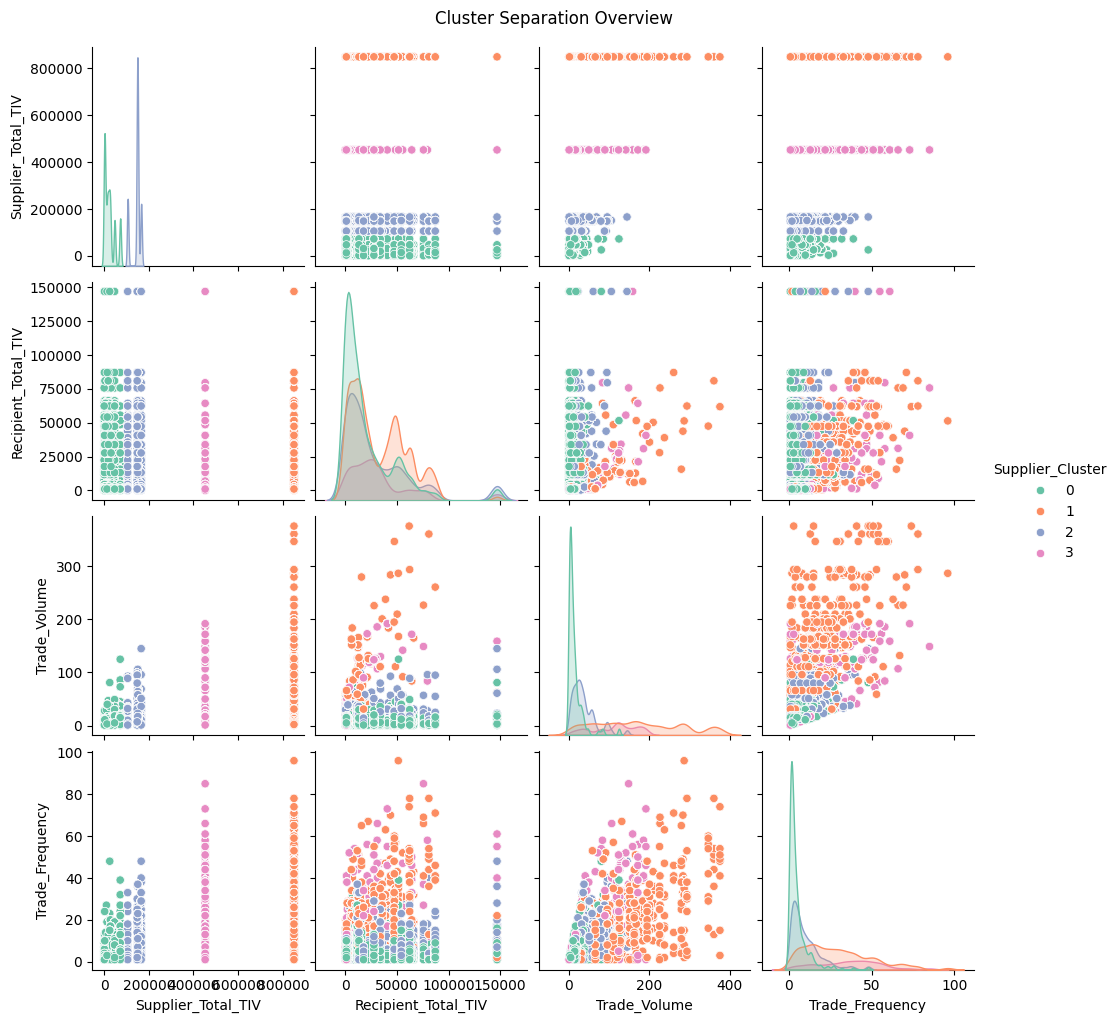

In [11]:
sns.pairplot(arms_enhance_df, vars=features, hue='Supplier_Cluster', palette='Set2', diag_kind='kde')
plt.suptitle("Cluster Separation Overview", y=1.02)
plt.show()


The pairplot visually confirms what was evaluated in the cluster summary

When looking at the number of distinct suppliers in each cluster however, the skewed distribution found previously starts to make sense.

In [17]:
supplier_counts = arms_enhance_df[['Supplier', 'Supplier_Cluster_Label']].drop_duplicates().groupby('Supplier_Cluster_Label').size()
print(supplier_counts)


Supplier_Cluster_Label
Balanced Traders            1
Global Power Exporters      1
Low-Activity States       130
Regional Exporters          4
dtype: int64


Astonishingly, only 6 countries globaly have a relatively significant impact on the arms trade and, according to the clustering, make up for roughly 75% of imports and exports.

Confirming now that our labels have been applied

In [12]:
arms_enhance_df.head(20)

,OrderDate,TransactionID,Recipient,Supplier,Number ordered,Weapon designation,Weapon description,Number delivered,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons,Supplier_Total_TIV,Recipient_Total_TIV,Trade_Volume,Decade,Trade_Frequency,Supplier_Cluster,Supplier_Cluster_Label
0,2002-01-01,Russia_2002.0_0,Afghanistan,Russia,3.0,Mi-17,transport helicopter,3.0,Second hand,Second-hand; aid,2.90,8.70,8.70,165817.26,15809.14,11,2000.0,6,2,Regional Exporters
1,2007-01-01,Turkiye_2007.0_1,Afghanistan,Turkiye,24.0,M-114 155mm,towed gun,24.0,Second hand,Second-hand; aid,0.20,4.80,4.80,6689.54,15809.14,1,2000.0,1,0,Low-Activity States
2,2004-01-01,United States_2004.0_2,Afghanistan,United States,188.0,M-113,armoured personnel carrier,188.0,Second hand,Second-hand; aid; M-113A2 version; incl 15 M-5...,0.10,18.80,18.80,849588.93,15809.14,34,2000.0,3,1,Global Power Exporters
3,2016-01-01,United States_2016.0_3,Afghanistan,United States,53.0,S-70 Black Hawk,transport helicopter,53.0,Second hand but modernized,Second-hand UH-60A modernized to UH-60A+ befor...,4.29,227.37,227.37,849588.93,15809.14,34,2010.0,31,1,Global Power Exporters
4,1973-01-01,Soviet Union_1973.0_4,Afghanistan,Soviet Union,100.0,T-62,tank,100.0,New,No additional info,1.80,180.00,180.00,452121.07,15809.14,82,1970.0,25,3,Balanced Traders
5,1978-01-01,Soviet Union_1978.0_5,Afghanistan,Soviet Union,500.0,T-55,tank,500.0,Second hand,Second-hand; aid,0.50,250.00,250.00,452121.07,15809.14,82,1970.0,25,3,Balanced Traders
6,1960-01-01,Soviet Union_1960.0_6,Afghanistan,Soviet Union,50.0,BM-13 132mm,multiple rocket launcher,50.0,Second hand,Second-hand,0.08,4.00,4.00,452121.07,15809.14,82,1960.0,18,3,Balanced Traders
7,2017-01-01,United States_2017.0_7,Afghanistan,United States,250.0,Paveway,guided bomb,250.0,New,Paveway-2 version; for Super Tucano (A-29B) tr...,0.02,5.00,5.00,849588.93,15809.14,34,2010.0,31,1,Global Power Exporters
8,2012-01-01,United States_2012.0_8,Afghanistan,United States,71.0,M-1117 Guardian,armoured personnel carrier,71.0,New,$79 m deal; MSFV version,0.40,28.40,28.40,849588.93,15809.14,34,2010.0,31,1,Global Power Exporters
9,2011-01-01,United States_2011.0_9,Afghanistan,United States,240.0,M-1117 Guardian,armoured personnel carrier,240.0,New,$257 m deal; MSFV version; incl command post; ...,0.40,96.00,96.00,849588.93,15809.14,34,2010.0,31,1,Global Power Exporters


I will load the clustered dataset as a csv file into the Processed folder, you shouldn't need to run this cell.

In [ ]:
arms_enhance_df.to_csv('data_folder/Processed/arms_trade_clustered.csv', index=False)

---

# Conclusions

This notebook successfully clustered countries based on their arms trade activity, identifying four distinct groups: Low-Activity States, Global Power Exporters, Regional Exporters, and Balanced Traders. The clustering approach, using log-transformed and standardized features, provided clear separation and interpretable results. The cluster labels have been joined to the main dataset, making further analysis and visualization straightforward.

## Next Steps: Dashboard Creation

With the clustering pipeline complete and cluster labels integrated, the next logical step is to build an interactive dashboard. This dashboard will allow users to:

- Explore profiles of dominating suppliers and compare countries within and across clusters.
- Visualize trade volumes, frequencies, and cluster distributions using interactive charts.
- Filter and drill down by region, cluster, or supplier/recipient.
- Present summary statistics and trends over time.

**Preparation:**  
- Prototype key visualizations (e.g., cluster maps, bar charts, time series).
- Design user-friendly layouts and navigation.
